In [1]:
# Install imageio for creating animations.  
!pip -q install imageio
!pip -q install scikit-image
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
import tensorflow_hub as hub

progan = hub.load("https://tfhub.dev/google/progan-128/1").signatures['default']


2023-03-07 01:44:22.570780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from absl import logging
from PIL import Image

import imageio
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.random.set_seed(0)

import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import time

try:
  from google.colab import files
except ImportError:
  pass

from IPython import display
from skimage import transform

# We could retrieve this value from module.get_input_shapes() if we didn't know
# beforehand which module we will be using.
latent_dim = 512


# Interpolates between two vectors that are non-zero and don't both lie on a
# line going through origin. First normalizes v2 to have the same norm as v1. 
# Then interpolates between the two vectors on the hypersphere.
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)

# Simple way to display an image.
def display_image(image):
  image = tf.constant(image)
  image = tf.image.convert_image_dtype(image, tf.uint8)
  return PIL.Image.fromarray(image.numpy())

# Given a set of images, show an animation.
def animate(images):
  images = np.array(images)
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  return embed.embed_file('./animation.gif')

logging.set_verbosity(logging.ERROR)

In [4]:
import os
print(os.getcwd())



/Users/xuxuqian/Documents/MSc-Coding-2-master/Week-7-notebooks


In [5]:
image = Image.open("/Users/xuxuqian/Desktop/000025.jpg")
image = image.resize((128, 128))


In [6]:
image_array = np.array(image) / 255.0


In [7]:
image_tensor = tf.convert_to_tensor(image_array)
image_tensor = tf.reshape(image_tensor, [1, 128, 128, 3])

In [8]:
image_tensor = tf.cast(image_tensor, dtype=tf.float32)

generated_image = progan(image_tensor)['default']




In [ ]:
def interpolate_between_vectors():
  v1 = tf.random.normal([latent_dim])
  v2 = tf.random.normal([latent_dim])
    
  # Creates a tensor with 25 steps of interpolation between v1 and v2.
  vectors = interpolate_hypersphere(v1, v2, 50)

  # Uses module to generate images from the latent space.
  interpolated_images = progan(vectors)['default']

  return interpolated_images

interpolated_images = interpolate_between_vectors()
animate(interpolated_images)

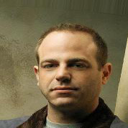

In [10]:
image_from_module_space = True  # @param { isTemplate:true, type:"boolean" }

def get_module_space_image():
  vector = tf.random.normal([1, latent_dim])
  images = progan(vector)['default'][0]
  return images

def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[list(uploaded.keys())[0]])
  return transform.resize(image, [128, 128])


target_image = np.array(image)
target_image = tf.cast(target_image, tf.float64)

target_image = target_image / 255.0 # Normalize the pixels in the image
display_image(target_image)


In [11]:
tf.random.set_seed(42)
initial_vector = tf.random.normal([1, latent_dim])

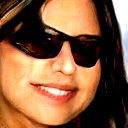

In [12]:
display_image(progan(initial_vector)['default'][0])

Run 1

....................................................................................................
....................................................................................................

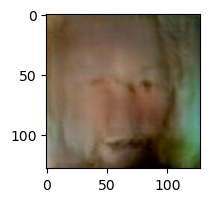

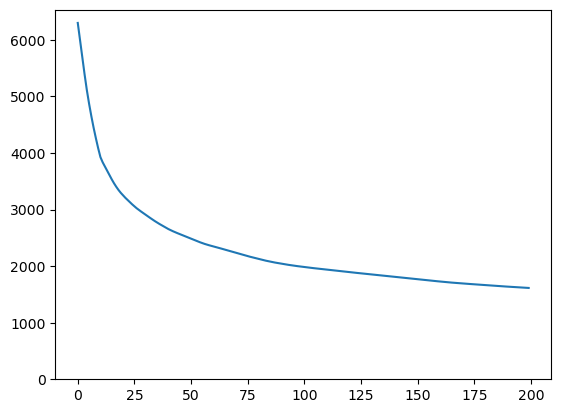

Run 2

....................................................................................................
....................................................................................................

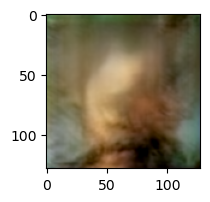

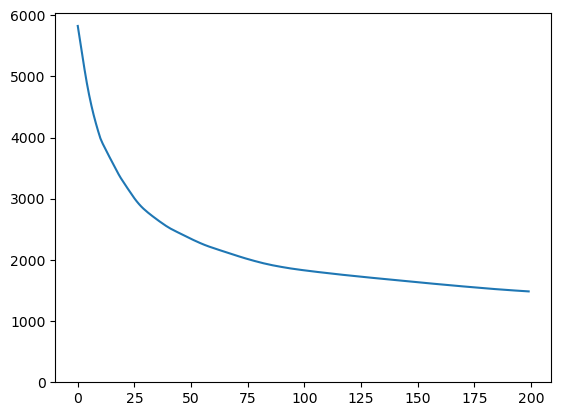

Run 3

....................................................................................................
....................................................................................................

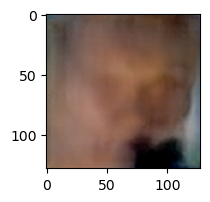

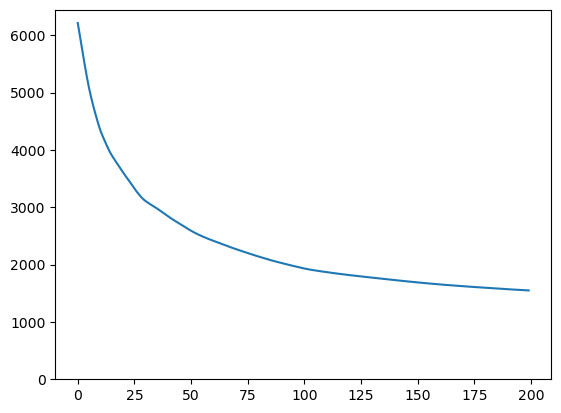

ValueError: Too many dimensions: 4 > 2.

In [31]:
def find_closest_latent_vector(num_runs, num_optimization_steps, steps_per_image):
  all_losses = []  # 用于存储每次运行的损失值列表
  all_images = []  # 用于存储所有运行中生成的图像

  for run in range(num_runs):
    print(f"Run {run + 1}")
    initial_vector = tf.random.normal(shape=(1, latent_dim))

    images = []  # 用于存储本次运行中生成的图像
    losses = []

    vector = tf.Variable(initial_vector)  
    optimizer = tf.optimizers.Adam(learning_rate=0.01)
    loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")

    for step in range(num_optimization_steps):
      if (step % 100)==0:
        print()
      print('.', end='')
      with tf.GradientTape() as tape:
        image = progan(vector.read_value())['default'][0]
        target_image_difference = loss_fn(image, tf.cast(target_image[:,:,:3], tf.float32))
        if (step % steps_per_image) == 0:
          images.append(image.numpy())
        # The latent vectors were sampled from a normal distribution. We can get
        # more realistic images if we regularize the length of the latent vector to 
        # the average length of vector from this distribution.
        regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))

        loss = target_image_difference + regularizer
        losses.append(loss.numpy())
      grads = tape.gradient(loss, [vector])
      optimizer.apply_gradients(zip(grads, [vector]))

    # Save the final generated image and loss values for each run
    final_image = image.numpy()
    final_loss = loss.numpy()
    np.save(f"generated_image_{run}.npy", final_image)
    np.save(f"loss_values_{run}.npy", losses)
    
    # 将本次运行中的图像列表添加到总图像列表中
    all_images.append(images)

    image = np.load(f"generated_image_{run}.npy")
    fig = plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.savefig(f"generated_image_{run}.png")
    plt.show()
 
    all_losses.append(losses)  # 将本次运行的损失值列表添加到all_losses中
    mean_losses = np.mean(all_losses, axis=0)
    plt.plot(mean_losses)
    plt.ylim([0,max(plt.ylim())])
    plt.show()

  # 将所有图像堆叠在一起并生成动画
  all_images = np.stack(all_images)
  animate(all_images)

  return

num_runs = 3
num_optimization_steps = 200
steps_per_image = 5
find_closest_latent_vector(num_runs, num_optimization_steps, steps_per_image)


In [ ]:
animate(np.stack(all_images))

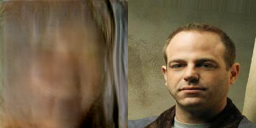

In [31]:
display_image(np.concatenate([images[-1], target_image], axis=1))